
### **Chapter 7.1: Model-Based Reinforcement Learning**



In this chapter, we introduce reinforcement learning, a powerful and widely used framework for solving constrained optimal control problems in both linear and nonlinear systems.

All the contents are summarized in the table below.  


<table border="1" style="border-collapse: collapse; text-align: center;">
  <!-- Title Row -->
  <tr>
    <th colspan="2" style="text-align:center">Content of Chapter 7.1 Exercise</th>
  </tr>

  <!-- Row group 1 -->
  <tr>
    <td rowspan="2">Discretization I</td>
    <td>Nearest Neighbor</td>
  </tr>
  <tr>
  </tr>

  <!-- Row group 2 -->
  <tr>
    <td rowspan="4">Value Iteration</td>
    <td>Task 1: Linear Case</td>
  </tr>
  <tr>
    <td>Task 2: Nonlinear Case</td>
  </tr>
  <tr>
  </tr>
  <tr>
  </tr>

  <!-- Row group 3 -->
  <tr>
    <td rowspan="2">Discretization II</td>
    <td>Linear Interpolation</td>
  </tr>
  <tr>
  </tr>

  <!-- Row group 4 -->
  <tr>
    <td rowspan="4">Policy Iteration</td>
    <td>Task 1: Nonlinear Case</td>
  </tr>
  <tr>
  </tr>
  <tr>
  </tr>
  <tr>
  </tr>

  <!-- Row group 4 -->
  <tr>
    <td rowspan="1">Comparison</td>
    <td>Model-Based RL vs. NMPC</td>
  </tr>

</table>

First, we need to set up our Python environment, import relevant packages, and setup some needed functions.

In [1]:
import sys
import os
from functools import wraps
sys.path.append(os.path.abspath(".."))
from rest.utils import *

# import time
import matplotlib
import numpy as np
import casadi as ca


def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    From: https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    # plt.register_cmap(cmap=newcmap)
    matplotlib.colormaps.register(name=name, cmap=newcmap)

    return newcmap


orig_cmap = matplotlib.cm.coolwarm
midpoint = 1 - 10 / (10 + 1)
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name='shiftedcmap')

### **Problem Setup:**

- Task: starting from given initial position $p_0$, reach a given target position $p_T$ (stabilization)

- Slope profile (height $h$ with reference to horizontal displacement $p$):  
   - case 1: zero slope (linear case), $h(p) = c$
   - case 2: constant slope (linear case), $h(p) = \frac{\pi}{18} \cdot p$
   - case 3: varying slope for small disturbances (nonlinear case), $h(p) = k \cdot \cos(18 p)$
   - case 4: varying slope for under actuated case (nonlinear case), $h(p) = \begin{cases} k \cdot \sin(3 p), & p \in [- \frac{\pi}{2}, \frac{\pi}{6}] \\ k, & p \in (-\infty, -\frac{\pi}{2}) \cup (\frac{\pi}{6}, \infty) \end{cases}$

- System dynamics of 1d mountain car model (in state space representation): 
   - state vector $\boldsymbol{x} = [p, v]^T$
   - input vector $u$
   - system dynamics:
   \begin{align*}
     \begin{bmatrix} \dot{p} \\ \dot{v} \end{bmatrix} = \begin{bmatrix} v \\ - g \sin(\theta) \cos(\theta) \end{bmatrix} + \begin{bmatrix} 0 \\ \cos(\theta)  \end{bmatrix} u
   \end{align*}

### **Preparation: Mountain Car Environment and the System Dynamics**

In the previous exercise, we demonstrated how to define a symbolic function using CasADi, including the definition of the mountain profile as a function of $p$, deriving the conversion formulas between the slope profile $h(p)$ and the inclination angle $\theta(p)$, and establishing the system's dynamics. These formulas have already been integrated into the class `Env` and `Dynamics`. In this chapter, we will specify the arguments and instantiate these classes directly to utilize their functionalities.

- Parameters in the task:  

   - case: 1 (linear case)
   
   - initial state: $\boldsymbol{x}_0 = [-0.5, 0.0]^T$

   - target state: $\boldsymbol{x}_T = [0.6, 0.0]^T$

   - input constraints: $ \mathcal{U} \in [-5.0, 5.0]$


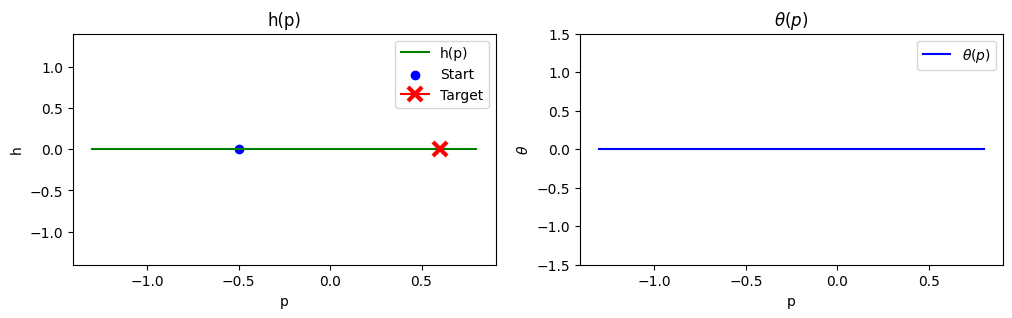

In [2]:
# Define profile of slope, the initial / target state
case = 1 
initial_position = -0.5
initial_velocity = 0.0
target_position = 0.6
target_velocity = 0.0

# State bounds
state_lbs = np.array([initial_position-0.8, -3.5])
state_ubs = np.array([target_position+0.2, 3.5])

# Input bounds
input_lbs = -5.0
input_ubs = 5.0

# Define the control frequency for controller
freq = 20
dt = 1.0/freq

# Constrained case
env_constr = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
                 input_lbs=input_lbs, input_ubs=input_ubs, state_lbs=state_lbs, state_ubs=state_ubs)
dynamics_constr = Dynamics(env_constr)
env_constr.test_env()

## Discretization I
### **Discretizing State and Input Spaces**

A Markov decision process (MDP), is the main assumption in RL. An MDP is the tuple $(\mathcal{X}, \mathcal{U}, p, r)$, where $\mathcal{X}$ is the discrete set of states, $\mathcal{U}$ is the discrete set of actions (can be state-dependent), $p$ describes the transition probabilities (conditional probability on the next state $x'$ given a state $x$ and an action $u$: $p(x' \vert x, u)$), and $r$ represents the reward for each transition with $r(x, u, x')$.  

However, many real-world problems (e.g., in robotics) have continuous state and action spaces or a mix of continuous and discrete spaces. In this section, we discuss the discretization of the state and input spaces. Then we will show how we compute the transition probabilities and rewards based on these discrete sets. We highlight two approaches: the nearest neighbor approach and the linear interpolation approach. Both approaches yield a stochastic MDP, that is, typically $p(x' \vert x, u) \leq 1$ for any $x'$, $x$, and $u$.

The selection of the discretization plays an important role. Typically, a finer discretization will lead to more accurate results that more closely represent the underlying continuous-time system. However, any additional discretization will lead to increased computation time. This computation scales poorly for higher dimensional state and action spaces (referred to as the curse of dimensionality). 

In this example, we choose a uniform discretization of states and inputs. However, we do make sure that the discrete states and actions exactly include the target state. In practice you may also consider using non-uniform discretizations, where the discretization steps vary. We show the discretization of the state and action spaces next. 

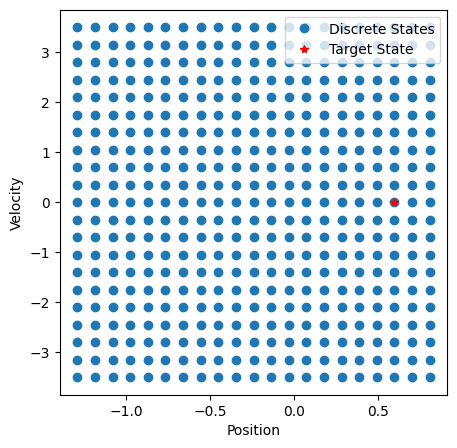

In [3]:
# Choose discretization
num_states = np.array([21, 21])
num_actions = 21

# function to create a linspace that includes a specific value called target
def linspace_include_target(target, lb, ub, num):
    assert target >= lb and target <= ub, "Target is out of bounds"
    # Create the original linspace
    linspace_array = np.linspace(lb, ub, num)

    # Find the closest index to target_pos
    closest_idx = np.argmin(np.abs(linspace_array - target))

    # Calculate the difference and shift the entire array
    difference = target - linspace_array[closest_idx]
    linspace_array += difference

    return linspace_array

num_pos = num_states[0]
num_vel = num_states[1]

pos_partitions = linspace_include_target(target_position, state_lbs[0], state_ubs[0], num_pos)  # make sure to include target_position
vel_partitions = linspace_include_target(target_velocity, state_lbs[1], state_ubs[1], num_vel)  # make sure to include target_velocity
acc_partitions = linspace_include_target(0.0, input_lbs, input_ubs, num_actions)  # make sure to include 0.0

plot_discrete_state_space(pos_partitions, vel_partitions, [target_position, target_velocity])

#### **Reward Function**
For any transition we incur a reward. For this example, we use the reward function:
$r(x, u, x') = \begin{cases} 10, & \text{if }x' \text{ is target state} \\ -1, & \text{if }x' \text{ is not target state} \end{cases}$

If the discrete state space is not inlcuded in the target state, we could assign the maximum reward to the discrete state closest to the target state. However, in our case, we have already made sure that they are part of the discrete set by design. 

While the RL agent assumes a discrete set of states and actions, the underlying system is still continuous and is potentially not even constrained to the same state and action bounds. That's why any resulting states $x' \notin \mathcal{X}$, will be projected back onto the closest state in $\mathcal{X}$. 

In [4]:
# The kdtree is a data structure that allows for efficient nearest neighbor search in a high-dimensional space.
kdtree_pos = cKDTree(pos_partitions.reshape(-1, 1))
kdtree_vel = cKDTree(vel_partitions.reshape(-1, 1))
kdtree_acc = cKDTree(acc_partitions.reshape(-1, 1))

def nearest_state_index_lookup_kdtree(state):
    """
    Find the nearest state index in the discrete state space for a given state.
    """
    nearest_pos_idx = kdtree_pos.query(state[0])[1]
    nearest_vel_idx = kdtree_vel.query(state[1])[1]
    return nearest_pos_idx + nearest_vel_idx * num_pos

target_state_index = nearest_state_index_lookup_kdtree(env_constr.target_state)

def one_step_forward(cur_state, cur_input):
    # Check whether current state and input is within the state space and input space
    cur_pos = max(min(cur_state[0], env_constr.pos_ubs), env_constr.pos_lbs)
    cur_vel = max(min(cur_state[1], env_constr.vel_ubs), env_constr.vel_lbs)
    cur_state = np.array([cur_pos, cur_vel])
    cur_input = max(min(cur_input, env_constr.input_ubs), env_constr.input_lbs)
    
    # Propagate the state
    next_state = dynamics_constr.one_step_forward(cur_state, cur_input, dt)  
    next_state_raw = next_state

    # Check whether next state is within the state space
    next_pos = max(min(next_state[0], env_constr.pos_ubs), env_constr.pos_lbs)
    next_vel = max(min(next_state[1], env_constr.vel_ubs), env_constr.vel_lbs)
    next_state = np.array([next_pos, next_vel])
    
    # Get reward
    next_state_index = nearest_state_index_lookup_kdtree(next_state)
    if next_state_index == target_state_index:
        reward = 10
    elif np.any(next_state_raw != next_state):
        reward = -1
    else:
        reward = -1
    
    return next_state, reward

#### **Transition Probabilities**

##### **Nearest Neighbor**

In the nearest neighbor approach, the next continuous state $x'$ is mapped to the closest node in the uniform mesh. This yields a deterministic MDP. In practice you may also want to add noise to the system and sample the system multiple times to better represent the continuous action space. We leave playing around with these parameters as an exercise to you. 


In [5]:
num_samples = 1
state_noise_levels = np.array([0.0, 0.0])
input_noise_levels = np.array([0.0])

pos, vel = np.meshgrid(pos_partitions, vel_partitions)
state_space = np.vstack((pos.ravel(), vel.ravel()))  # Shape: (2, num_states)
num_total_states = state_space.shape[1]

# Define action space (acceleration)
input_space = acc_partitions  # Shape: (1, num_actions)
num_actions = len(input_space)

def nearest_neighbor_approach(cur_state, action):
    probs = []
    nodes = []
    rewards = []
    for i in range(num_samples):
        # Sample noise
        state_noise = np.random.normal(0, 1.0, size=cur_state.shape) * state_noise_levels
        input_noise = np.random.normal(0, 1.0, size=1) * input_noise_levels

        # Propagate forward to get next state and reward
        next_state, reward = one_step_forward(cur_state + state_noise, action + input_noise)

        probs.append(1.0 / num_samples)
        nodes.append(next_state)
        rewards.append(reward / num_samples)

    return probs, nodes, rewards

def build_stochastic_mdp(approach, verbose=False):
    """
    Construct transition probability (T) and reward (R) matrices for the MDP.
    """

    # Initialize T and R matrices
    T = np.zeros((num_actions, num_total_states, num_total_states))
    R = np.zeros((num_actions, num_total_states, num_total_states))

    # Iterate over all states
    for state_index in range(num_total_states):
        cur_state = state_space[:, state_index]
        print(f"Building model... state {state_index + 1}/{num_states}")

        # Apply each possible action
        for action_index in range(num_actions):
            action = input_space[action_index]

            if verbose:
                print(f"cur_state: {cur_state}")
                print(f"action: {action}")

            probs, nodes, rewards = approach(cur_state, action)

            # Update transition and reward matrices
            for i, node in enumerate(nodes):
                node_index = nearest_state_index_lookup_kdtree(node)
                
                T[action_index][state_index, node_index] += probs[i]
                R[action_index][state_index, node_index] += rewards[i]

    return T, R

Now we can create the transition probabilities and reward function for our environment and task.  

In [6]:
T_nn, R_nn = build_stochastic_mdp(nearest_neighbor_approach, verbose=True)


Building model... state 1/[21 21]
cur_state: [-1.29 -3.5 ]
action: -5.0
cur_state: [-1.29 -3.5 ]
action: -4.5
cur_state: [-1.29 -3.5 ]
action: -4.0
cur_state: [-1.29 -3.5 ]
action: -3.5
cur_state: [-1.29 -3.5 ]
action: -3.0
cur_state: [-1.29 -3.5 ]
action: -2.5
cur_state: [-1.29 -3.5 ]
action: -2.0
cur_state: [-1.29 -3.5 ]
action: -1.5
cur_state: [-1.29 -3.5 ]
action: -1.0
cur_state: [-1.29 -3.5 ]
action: -0.5
cur_state: [-1.29 -3.5 ]
action: 0.0
cur_state: [-1.29 -3.5 ]
action: 0.5
cur_state: [-1.29 -3.5 ]
action: 1.0
cur_state: [-1.29 -3.5 ]
action: 1.5
cur_state: [-1.29 -3.5 ]
action: 2.0
cur_state: [-1.29 -3.5 ]
action: 2.5
cur_state: [-1.29 -3.5 ]
action: 3.0
cur_state: [-1.29 -3.5 ]
action: 3.5
cur_state: [-1.29 -3.5 ]
action: 4.0
cur_state: [-1.29 -3.5 ]
action: 4.5
cur_state: [-1.29 -3.5 ]
action: 5.0
Building model... state 2/[21 21]
cur_state: [-1.185 -3.5  ]
action: -5.0
cur_state: [-1.185 -3.5  ]
action: -4.5
cur_state: [-1.185 -3.5  ]
action: -4.0
cur_state: [-1.185 -3.5  

Let's visualize the resulting transition probabilities and rewards.

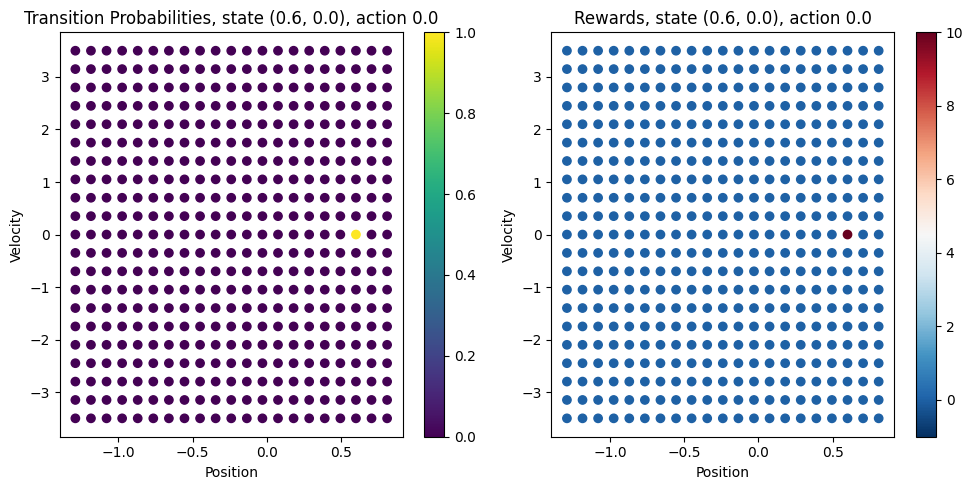

In [8]:
action_id = int(num_actions / 2.0)
state_id = target_state_index

def visualize_T_and_R(state_id, action_id, T, R):
    pos = pos_partitions[((state_id) % num_pos)]
    vel = vel_partitions[((state_id) // num_pos)]
    acc = acc_partitions[action_id]

    T_next = T[action_id, state_id]
    R_next = R[action_id, state_id]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    pos_grid, vel_grid = np.meshgrid(pos_partitions, vel_partitions)

    # Plot transition probabilities
    T_plot = ax1.scatter(pos_grid.flatten(), vel_grid.flatten(), c=T_next, cmap='viridis', vmin=0, vmax=1)
    ax1.set_xlabel('Position')
    ax1.set_ylabel('Velocity') 
    ax1.set_title(f'Transition Probabilities, state ({pos}, {vel}), action {acc}')
    plt.colorbar(T_plot, ax=ax1)

    # Plot rewards
    R_plot = ax2.scatter(pos_grid.flatten(), vel_grid.flatten(), c=R_next, cmap='RdBu_r', vmin=-1, vmax=10)
    ax2.set_xlabel('Position')
    ax2.set_ylabel('Velocity')
    ax2.set_title(f'Rewards, state ({pos}, {vel}), action {acc}')
    plt.colorbar(R_plot, ax=ax2)

    plt.tight_layout()
    plt.show()

visualize_T_and_R(target_state_index, action_id, T_nn, R_nn)

Since the arrays that hold the transition probabilities and the rewards are high dimensional, you are encouraged to try different values for the `state_id` and the `action_id` (although the deterministic case won't provide too many surprises). 

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Stochastic MDP from Nearest Neighbor**

Experiment with the amount of noise added to the state and control inputs to record the state transitions and vary the number of sampled points. this will lead to a stochastic MDP instead of a deterministic one. What do you observe? Can the added noise make up for the coarse discretization?

## Value Iteration

After setting up the MDP, the common interface to any RL algorithm, we now apply the standard RL algorithms, value and policy iteration to this MDP.  We begin with the value iteration algorithm. The implementation directly follows the lecture notes. To prevent infinite loops, we limit the maximum number of iterations. 

In [9]:
vi_eps = 1e-6
max_vi_ite = 500

@timing
def value_iteration(T, R, gamma=1.0, max_vi_ite=500):
    v_collection = []
    policy_collection = []

    v = np.zeros((num_total_states))
    policy = np.zeros((num_total_states), np.int32)
    
    current_eps = vi_eps + 1.0  # make sure the first value is larger so at least one iteration is executed. 

    vi_iteration = 0

    while current_eps >= vi_eps and vi_iteration < max_vi_ite:
        v_new = np.zeros((num_total_states))

        current_eps = 0.0

        for state_index in range(num_total_states):
            v_actions = np.zeros((num_actions))
            for action_index in range(num_actions):
                for next_state_index in range(num_total_states):
                    v_actions[action_index] += T[action_index, state_index, next_state_index] * (R[action_index, state_index, next_state_index] + gamma * v[next_state_index])
            best_action_index = np.argmax(v_actions)
            v_new[state_index] = v_actions[best_action_index]
            policy[state_index] = best_action_index

            current_eps = max(current_eps, np.abs(v_new[state_index] - v[state_index]))

        v = v_new

        print(f"Iteration {vi_iteration}: Current eps: {current_eps}")
        vi_iteration += 1
        v_collection.append(v)
        policy_collection.append(policy.copy())

    return v, policy, v_collection, policy_collection

Before we run value iteration, we will fix the discount factor $\gamma$ for the remainder of the notebook. We encourage you to play around with different values for $\gamma$. What effects can you observe?

In [10]:
gamma = 0.9

#### Task 1: Linear Case
Now everything is set up for running the value iteration algorithm. For fine discretizations this can take some time. 

In [11]:
vi_nn_v, vi_nn_policy, vi_nn_v_collection, vi_nn_policy_collection = value_iteration(T_nn, R_nn, gamma)

Iteration 0: Current eps: 10.0
Iteration 1: Current eps: 9.0
Iteration 2: Current eps: 8.100000000000001
Iteration 3: Current eps: 7.290000000000002
Iteration 4: Current eps: 6.561000000000002
Iteration 5: Current eps: 5.904900000000001
Iteration 6: Current eps: 5.314410000000002
Iteration 7: Current eps: 4.782969000000001
Iteration 8: Current eps: 4.304672100000002
Iteration 9: Current eps: 3.8742048900000023
Iteration 10: Current eps: 3.486784401000002
Iteration 11: Current eps: 3.138105960900006
Iteration 12: Current eps: 2.8242953648100055
Iteration 13: Current eps: 2.5418658283290085
Iteration 14: Current eps: 2.2876792454961077
Iteration 15: Current eps: 2.0589113209464998
Iteration 16: Current eps: 1.8530201888518505
Iteration 17: Current eps: 1.667718169966662
Iteration 18: Current eps: 1.5009463529700042
Iteration 19: Current eps: 1.3508517176730024
Iteration 20: Current eps: 1.2157665459057014
Iteration 21: Current eps: 1.094189891315132
Iteration 22: Current eps: 0.984770902

The value iteration algorithm also provides an associated policy. We will use this policy as a controller for our mountain car. This policy is a look-up-table. Based on our current state, we pick the action for the discrete state that is closest to the continuous state. This is implemented in the following cell. 

In [ ]:
import builtins
class RLController(BaseController):
    def __init__(self, 
                 env: Env, 
                 dynamics: Dynamics, 
                 freq: float, 
                 policy: np.ndarray,
                 name: str = 'RL', 
                 type: str = 'RL', 
                 verbose: bool = True
                 ) -> None:
        
        super().__init__(env, dynamics, freq, name, type, verbose)

        self.policy = policy
        # Add a dummy mdp attribute with required fields
        self.mdp = builtins.type('mdp', (), {})()
        self.mdp.num_pos = num_pos
        self.mdp.pos_ubs = env.pos_ubs
        self.mdp.pos_lbs = env.pos_lbs
        self.setup()

    def setup(self):
        pass

    @check_input_constraints
    def compute_action(self, current_state: np.ndarray, current_time) -> np.ndarray:
        """
        Use the optimal policy to compute the action for the given state.
        """
        # Find the nearest discrete state index
        state_index = nearest_state_index_lookup_kdtree(current_state)
        
        # Get the optimal action from the policy
        action_index = self.policy[state_index]
        action = input_space[action_index]

        return np.array([action])

Before we can run our policy, we are only left to set the time for the simulation. 

In [13]:
t_terminal = 8.0

Finally, we execute the resulting policy from value iteration to our system: 

In [ ]:
vi_nn_controller = RLController(env_constr, dynamics_constr, 1.0/dt, vi_nn_policy)

simulator_vi_nn = Simulator(dynamics_constr, vi_nn_controller, env_constr, dt, t_terminal)
simulator_vi_nn.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_vi_nn = Visualizer(simulator_vi_nn)
visualizer_vi_nn.display_plots()
visualizer_vi_nn.display_animation()

TypeError: 'str' object is not callable

As you can see, the resulting policy successfully achieves the task and stabilizes the system around the desired state. There are some oscialltions at the end since the policy only has access to a limited number of discrete actions. 

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Discount Factor $\gamma$**

To gain a better understanding of the discount factor, try running the cells for smaller and larger values of $\gamma$. Recall that $\gamma \in \left(0, 1\right)$. What do you observe? What is the impact of the discount factor? 

#### Task 2: Nonlinear Case
The above task was relatively simple and the linear methods, like LQR, were already able to solve such tasks. Therefore, the question becomes: How does this transfer to more challenging tasks? For the rest of the notebook, we are considering the case of the valley environment. We set up the new environment (using the previous constraints and target state). 

In [ ]:
# Define profile of slope, the initial / target state
case = 4

# Constrained case
env_constr = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
                 input_lbs=input_lbs, input_ubs=input_ubs, state_lbs=state_lbs, state_ubs=state_ubs)
dynamics_constr = Dynamics(env_constr)
env_constr.test_env()

Again, we set up the MDP. 

In [ ]:
T_nn, R_nn = build_stochastic_mdp(nearest_neighbor_approach, verbose=True)

In [ ]:
action_id = int(num_actions / 2.0)
state_id = target_state_index

visualize_T_and_R(target_state_index, action_id, T_nn, R_nn)

Then we run value iteration for this new task. 

In [ ]:
vi_nn_v, vi_nn_policy, vi_nn_v_collection, vi_nn_policy_collection = value_iteration(T_nn, R_nn, gamma)

In [ ]:
vi_nn_controller = RLController(env_constr, dynamics_constr, 1.0/dt, vi_nn_policy)

simulator_vi_nn = Simulator(dynamics_constr, vi_nn_controller, env_constr, dt, t_terminal)
simulator_vi_nn.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_vi_nn = Visualizer(simulator_vi_nn)
visualizer_vi_nn.display_plots()
visualizer_vi_nn.display_animation()

The resulting policy fails to successfully stabilize the system at the top. As you will see in the next part, this is not a limitation of the RL method but rather a limitation of the chosen discretization approach. You may try to increase the number of discrete states, but this will also result in a larger computational cost.

## Discretization II

### Linear Interpolation

Since the nearest neighbor approach did not stabilize the system on top of the hill, we turn to a different scheme to generate an MDP from a system with continuous dynamics, state, and inputs. 

In this section, we introduce the linear interpolation approach. This approach assigns probabilities to adjacent nodes based on the distance of the true continuous state to its adjacent nodes. Therefore, the linear interpolation approach is inherenetly stochastic and accounts for the possibility of landing in different states. 


In [ ]:
def linear_interpolation_approach(cur_state, action):
    # Propagate forward to get next state and reward
    next_state, reward = one_step_forward(cur_state, action)

    pos_indices = kdtree_pos.query(next_state[0], k=2)[1]
    vel_indices = kdtree_vel.query(next_state[1], k=2)[1]

    pos_bounds = [pos_partitions[pos_indices[0]], pos_partitions[pos_indices[1]]]
    vel_bounds = [vel_partitions[vel_indices[0]], vel_partitions[vel_indices[1]]]

    # Normalize next state within bounds
    x_norm = (next_state[0] - min(pos_bounds)) / (max(pos_bounds) - min(pos_bounds))
    y_norm = (next_state[1] - min(vel_bounds)) / (max(vel_bounds) - min(vel_bounds))

    # Calculate bilinear interpolation probabilities
    probs = [
        (1 - x_norm) * (1 - y_norm),  # bottom-left
        x_norm * (1 - y_norm),        # bottom-right
        x_norm * y_norm,              # top-right
        (1 - x_norm) * y_norm         # top-left
    ]

    # Four vertices of the enclosing box
    nodes = [
        [min(pos_bounds), min(vel_bounds)],  # bottom-left
        [max(pos_bounds), min(vel_bounds)],  # bottom-right
        [max(pos_bounds), max(vel_bounds)],  # top-right
        [min(pos_bounds), max(vel_bounds)]   # top-left
    ]

    rewards = [reward] * len(nodes)

    return probs, nodes, rewards

T_interp, R_interp = build_stochastic_mdp(linear_interpolation_approach, verbose=True)

Again, we visualize the resulting transition probabilities and rewards. 

In [ ]:
action_id = int(num_actions / 2.0)
state_id = target_state_index

visualize_T_and_R(target_state_index, action_id, T_interp, R_interp)

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Discretization Approaches**

Compare the resulting slices for the nearest neighbor approach and the linear intepolation approach. What do you see? How do they differ? When would you choose which approach? 

We now run value iteration for the newly created MDP.

In [ ]:
vi_interp_v, vi_interp_policy, vi_interp_v_collection, vi_interp_policy_collection = value_iteration(T_interp, R_interp, gamma)

In [ ]:
vi_interp_controller = RLController(env_constr, dynamics_constr, 1.0/dt, vi_interp_policy)

simulator_vi_interp = Simulator(dynamics_constr, vi_interp_controller, env_constr, dt, t_terminal)
simulator_vi_interp.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_vi_interp = Visualizer(simulator_vi_interp)
visualizer_vi_interp.display_plots()
visualizer_vi_interp.display_animation()

This time, value iteration is able to stabilize the system at the top of the hill. 

## Policy Iteration

The Bellman equation can be used to derive different algorithms to find the optimal value function and policy. Another algorithm is the policy iteration algorithm. Following the lecture notes, the algorithm is implmented in the following cell. 

In [ ]:
pe_eps = 1e-6

@timing
def policy_iteration( T, R, gamma=1.0, max_pe_ite=100, max_pi_ite=100):
    v_collection = []
    policy_collection = []

    v = np.zeros((num_total_states))
    median_action = int(num_actions / 2.0)
    policy = median_action * np.ones((num_total_states), np.int32)  # initialize the policy with the zero action for each state

    policy_converged = False

    pi_iteration = 0

    while not policy_converged and pi_iteration < max_pi_ite:

        v = policy_evaluation(v, policy, T, R, gamma, max_pe_ite)
        policy_converged, policy = policy_improvement(v, policy, T, R, gamma)

        pi_iteration += 1
        v_collection.append(v)  
        print(f"Policy improvement {pi_iteration}")
        policy_collection.append(policy.copy())

    return v, policy, v_collection, policy_collection

def policy_evaluation(v, policy, T, R, gamma=1.0, max_pe_ite=100):
    current_eps = pe_eps + 1.0
    pe_iteration = 0

    while current_eps >= pe_eps and pe_iteration < max_pe_ite:
        v_new = np.zeros((num_total_states))

        current_eps = 0.0

        for state_index in range(num_total_states):
            action_index = policy[state_index]
            for next_state_index in range(num_total_states):
                v_new[state_index] += T[action_index, state_index, next_state_index] * (R[action_index, state_index, next_state_index] + gamma * v[next_state_index])

            current_eps = max(current_eps, np.abs(v_new[state_index] - v[state_index]))

        v = v_new

        print(f"Policy evaluation {pe_iteration}: Current eps: {current_eps}")
        pe_iteration += 1

    return v

def policy_improvement(v, policy, T, R, gamma=1.0):
    policy_converged = True

    for state_index in range(num_total_states):
        u_old = policy[state_index]

        v_actions = np.zeros((num_actions))
        for action_index in range(num_actions):
            for next_state_index in range(num_total_states):
                v_actions[action_index] += T[action_index, state_index, next_state_index] * (R[action_index, state_index, next_state_index] + gamma * v[next_state_index])
        best_action_index = np.argmax(v_actions)
        policy[state_index] = best_action_index

        if not policy[state_index] == u_old:
            policy_converged = False 

    return policy_converged, policy


#### Task 1: Nonlinear Case

We directly use this algorithm for the new MDP to find the optimal policy. 

In [ ]:
pi_interp_v, pi_interp_policy, pi_interp_v_collection, pi_interp_policy_collection = policy_iteration(T_interp, R_interp, gamma)

In [ ]:
pi_interp_controller = RLController(env_constr, dynamics_constr, 1.0/dt, pi_interp_policy)

simulator_pi_interp = Simulator(dynamics_constr, pi_interp_controller, env_constr, dt, t_terminal)
simulator_pi_interp.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_pi_interp = Visualizer(simulator_pi_interp)
visualizer_pi_interp.display_plots()
visualizer_pi_interp.display_animation()

The resulting policy from policy iteration also stabilizes the system to the top of the hill. Here, both algorithms yield the same policy. This is not generally the case for both algorithms. Furthermore, policy iteration took only a quarter of the time compared to value iteration but results in the same optimal policy here. It is not always guaranteed that policy iteration will take less time to run. Rather it depends on which step (policy evaluation or policy improvement) takes more time. 

To highlight the differences between the two iterative algorithms, we visualize the optimal policy and optimal cost over time.

In [ ]:
def animate_value_policy_iterations(v_collection, policy_collection, pos_partitions, vel_partitions, animation_time=10.0, title='Value and Policy Iterations'):
    """
    Animate the optimal policy and optimal cost over time as resulting from value and policy iteration.
    Ensures consistent axes across all frames and subplots.
    """
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Create colorbars only once, outside the update function
    policy = policy_collection[0].reshape(num_pos, num_vel)
    v = v_collection[0].reshape(num_pos, num_vel)
    
    # Initial plots to create colorbars
    im1 = axs[0].imshow(policy, extent=[
        pos_partitions[0], pos_partitions[-1],
        vel_partitions[0], vel_partitions[-1]
    ], origin='lower', aspect='auto', cmap='viridis')
    cbar1 = fig.colorbar(im1, ax=axs[0], orientation='vertical')
    
    im2 = axs[1].imshow(v, extent=[
        pos_partitions[0], pos_partitions[-1],
        vel_partitions[0], vel_partitions[-1]
    ], origin='lower', aspect='auto', cmap='viridis')
    cbar2 = fig.colorbar(im2, ax=axs[1], orientation='vertical')

    # --- Animation frame update ---
    def update(frame_idx):

        v = v_collection[frame_idx]
        policy = policy_collection[frame_idx]

        axs[0].clear()
        axs[1].clear()

        fig.suptitle(f"{title}\nIteration = {frame_idx}", fontsize=14)

        # reshape policy and value function to 2D arrays
        policy = policy.reshape(num_pos, num_vel)
        v = v.reshape(num_pos, num_vel)

        # Plot policy (U)
        im1 = axs[0].imshow(policy, extent=[
            pos_partitions[0], pos_partitions[-1],
            vel_partitions[0], vel_partitions[-1]
        ], origin='lower', aspect='auto', cmap='viridis')
        axs[0].set_title('Optimal Policy')
        axs[0].set_xlabel('Car Position')
        axs[0].set_ylabel('Car Velocity')

        # Plot cost-to-go (J)
        im2 = axs[1].imshow(v, extent=[
            pos_partitions[0], pos_partitions[-1],
            vel_partitions[0], vel_partitions[-1]
        ], origin='lower', aspect='auto', cmap='viridis')
        axs[1].set_title('Value Function')
        axs[1].set_xlabel('Car Position')
        axs[1].set_ylabel('Car Velocity')
    
    num_frames = len(v_collection)
    interval_time = int(animation_time / num_frames * 1000.0)  # in milliseconds
    anim = FuncAnimation(fig, update, frames=num_frames, interval=interval_time, repeat=False)
    plt.close(fig)
    return HTML(anim.to_jshtml())

In [ ]:
animate_value_policy_iterations(vi_interp_v_collection, vi_interp_policy_collection, pos_partitions, vel_partitions, title='Value Iterations')

In [ ]:
animate_value_policy_iterations(pi_interp_v_collection, pi_interp_policy_collection, pos_partitions, vel_partitions, title='Policy Iterations')

You can see how the approaches take different numbers of iterations to converge and that the pattern of convergence is also different among the two approaches. 

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Value and Policy Iteration Variants**

1. The utils.py include an implementation of generalized policy iteration (GPI) as introduced in the lecture notes. Can you make GPI behave like value iteration of policy iteration for the nonlinear case? 

2. Implement the Gauss-Seidel approach. What do you observe when you use this modification when calculating the policy? 

## Comparison

#### Model-Based RL vs. Nonlinear MPC

Let's compare the resulting RL policy with the nonlinear MPC we saw in chapter 5. 

In [ ]:
# To find a feasible solution, the MPC requires a bit larger bounds (but does not use them)
state_lbs_mpc = np.array([-2.0, -4.0])
state_ubs_mpc = np.array([2.0, 4.0])

# Constrained case
env_constr_mpc = Env(case, np.array([initial_position, initial_velocity]), np.array([target_position, target_velocity]),
                 input_lbs=input_lbs, input_ubs=input_ubs, state_lbs=state_lbs_mpc, state_ubs=state_ubs_mpc)
dynamics_constr_mpc= Dynamics(env_constr_mpc)
env_constr_mpc.test_env()

In [ ]:
# Define weight matrix in stage and terminal cost
Q_weight = np.diag([1, 1])
R_weight = np.array([[0.1]])
Qf = Q_weight

N = 60

# Instantiate the MPC controller class (controller name must be different from the rest controllers)
controller_mpc_N60 = MPCController(env_constr_mpc, dynamics_constr_mpc, Q_weight, R_weight, Qf, freq, N, name="MPC_N60")

# Instantiate the simulator, run the simulation, and plot the results
simulator_mpc_N60 = Simulator(dynamics_constr, controller_mpc_N60, env_constr, 1/freq, t_terminal)
simulator_mpc_N60.run_simulation()

# Instantiate the visualizer, and display the plottings and animation
visualizer_mpc_N60 = Visualizer(simulator_mpc_N60)
visualizer_mpc_N60.display_plots(title='N = 60')
visualizer_mpc_N60.display_animation()

In [ ]:
# Show comparison between all cases
visualizer_vi_interp.display_contrast_plots(simulator_mpc_N60)
visualizer_vi_interp.display_contrast_animation_same(simulator_mpc_N60)

Both approaches lead the mountain car to the top of the hill. The model-based RL determines a policy over the state space offline while the MPC only determines an input for the current state online. Therefore, RL requires significant computation offline but its execution online is fast.

<blockquote style="padding-top: 20px; padding-bottom: 10px;">

##### **🔍 Hands-on Exploration: Model Mismatch**

Consider the case where the MDP does not precisely model the environment. What happens if you use an MDP designed for the linear case but apply it to the system with the nonlinear slope? Is the RL policy still able to achieve the stabilization goal? 